In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

In [ ]:
%load_ext nvcc_plugin

In [30]:
%%cu
#include <iostream>
#include <stdio.h>
#include <sys/time.h>

using namespace std;

#define ID(i,j,rows) ((j)*(rows)+(i))

double matmul_cpu(float* A, float* B, float* C, int K, int M, int N){
    struct timeval start, end;
    gettimeofday(&start, NULL);
    float t;
    for(int i = 0; i < K; i++)
      for(int j = 0; j < N; j++){
        t = 0;
        for(int k = 0; k < M; k++)
          t += A[ID(i,k,K)] * B[ID(k,j,M)];
        C[ID(i,j,K)] = t;
      }
    gettimeofday(&end, NULL);
    return (end.tv_sec - start.tv_sec) + ((double)end.tv_usec - start.tv_usec)/1000000;
}

__global__ void MatMul(float* A, float* B, float* C, int K, int M, int N)
{
    int x = blockIdx.y * blockDim.y + threadIdx.x;
    int y = blockIdx.x * blockDim.x + threadIdx.y;

    if(y >= N || x >= K)
      return;

    float value = 0.0;
    for(int i = 0; i < M; i++)
        value += A[ID(x,i,K)] * B[ID(i,y,M)];
    C[ID(x,y,K)] = value;
 
    return;
}

double matmul_gpu(float* A, float* B, float* C, int K, int M, int N){
    dim3 blockDim(10, 10);
    dim3 gridDim((N-1)/blockDim.x + 1, (K-1)/blockDim.y + 1);

    float* cudaA;
    float* cudaB;
    float* cudaC;

    cudaMalloc(&cudaA, K * M * sizeof(float));
    cudaMalloc(&cudaB, M * N * sizeof(float));
    cudaMalloc(&cudaC, K * N * sizeof(float));

    cudaMemcpy(cudaA, A, K * M * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(cudaB, B, M * N * sizeof(float), cudaMemcpyHostToDevice);

    cudaEvent_t start, end;
    cudaEventCreate(&start);
    cudaEventCreate(&end);

    float gpu_time = 0.0f;
	
    cudaEventRecord(start);

    MatMul <<< gridDim, blockDim >>> (cudaA, cudaB, cudaC, K, M, N);

    cudaThreadSynchronize();
    cudaEventRecord(end);
    cudaDeviceSynchronize();
	
    cudaEventElapsedTime(&gpu_time, start, end);

    cudaMemcpy(C, cudaC, K * N * sizeof(float), cudaMemcpyDeviceToHost);

    cudaFree(cudaA);
    cudaFree(cudaB);
    cudaFree(cudaC);

    return gpu_time/1000;
}

void print_matrix(float* A, int rows, int cols){
    for(int i = 0; i < rows; i++){
      for(int j = 0; j < cols; j++)
        cout << A[ID(i,j,rows)] << " ";
      cout << endl;
    }
    cout << endl;
}

float dif_matrix(float* A, float* B, int l){
    float rez = 0;
    for(int i = 0; i < l; i++)
      rez += (A[i] - B[i]) * (A[i] - B[i]);
    return rez;
}

int main() {
    //int same = 2000;
	  int K = 1000, M = 200, N = 350;

    float* A = (float *)malloc(K * M * sizeof(float));
    float* B = (float *)malloc(M * N * sizeof(float));
    float* C_cpu = (float *)malloc(K * N * sizeof(float));
    float* C_gpu = (float *)malloc(K * N * sizeof(float));
	
    srand(time(0));
    for (int j = 0; j < K*M; j++)
      A[j] = rand()%10 + 0.1;
    for (int j = 0; j < M*N; j++)
      B[j] = rand()%10 + 0.2;

    double rez_cpu = matmul_cpu(A, B, C_cpu, K, M, N);
    double rez_gpu = matmul_gpu(A, B, C_gpu, K, M, N);

    //print_matrix(A, K, M);
    //print_matrix(B, M, N);
    //print_matrix(C_cpu, K, N);

    //cout << "N = " << same << endl;
    cout << "cpu: " << rez_cpu << " sec" << endl;
    cout << "gpu: " << rez_gpu << " sec" << endl;
    cout << "dif: " << dif_matrix(C_cpu, C_gpu, K * N) << endl;
	
    free(A);
    free(B);
    free(C_cpu);
    free(C_gpu);
    return 0;
}

cpu: 0.228043 sec
gpu: 0.00082832 sec
dif: 0.00532365



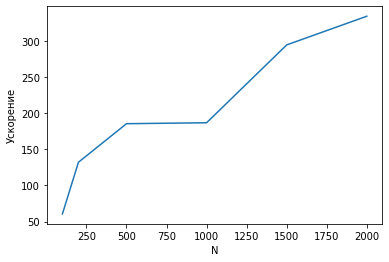

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.xlabel('N')
plt.ylabel('Ускорение')
x = np.array([100, 200, 500, 1000, 1500, 2000])
cpu = np.array([0.003005, 0.024642, 0.435389, 3.71716, 18.6932, 67.5547])
gpu = np.array([4.9568e-05, 0.000186528, 0.002348, 0.019907, 0.0634924, 0.202216])
plt.plot(x, cpu/gpu)
plt.show()